In [1]:
import os
import numpy as np
from transformers.models.roberta.tokenization_roberta import RobertaTokenizer
from transformers.optimization import AdamW
from transformers.models.roberta.modeling_roberta import RobertaModel

import torch
import torch.nn as nn
import random
from torch.nn import functional as F

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

2023-05-16 06:51:30.840011: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 加载数据

In [2]:
Cbase_pretrain_path = '../EMNLP2023/Dataset/Processed/HWU/Pretrain.txt'
Cbase_x = []
Cbase_y = []
for line in open(Cbase_pretrain_path):
    if len(line.split('\t')) != 2:
        continue
    else:
        Cbase_y.append(line.split('\t')[1][:-1].replace('_',' '))
        Cbase_x.append(line.split('\t')[0])

label_yd_yi_dic = {'play podcasts': '0', 'alarm set': '1', 'takeaway query': '2', 'social post': '3', 'email querycontact': '4', 'iot wemo off': '5', 'iot hue lightup': '6', 'general affirm': '7', 'calendar set': '8', 'general negate': '9', 'iot coffee': '10', 'news query': '11', 'recommendation events': '12', 'play audiobook': '13', 'play radio': '14', 'alarm remove': '15', 'iot hue lightdim': '16', 'datetime query': '17', 'recommendation movies': '18', 'social query': '19', 'play game': '20', 'datetime convert': '21', 'iot hue lightoff': '22', 'music likeness': '23', 'email sendemail': '24', 'general quirky': '25', 'weather query': '26', 'transport taxi': '27', 'lists query': '28', 'qa factoid': '29', 'transport traffic': '30', 'general joke': '31'}

print(len(set(Cbase_y)))

32


In [3]:
# 1 model initialization
# encoder
max_length = 32
n_tokens = 5
hidden_size = 1024

# 2 hyper-parameters initialization
batch_size = 10
cluster_nums = len(list(set(Cbase_y)))
cluster_nums_str = str(cluster_nums)

# 3 training parameters
base_lr = 5e-6
lr_scale = 100

In [4]:
Cn_path = '../EMNLP2023/Dataset/Processed/HWU/Aux1PMulti.txt'
Cn = []
for line in open(Cn_path):
    Cn.append(line)
random.shuffle(Cn)

Cn_x = []
Cn_y = []
for line in Cn:
    Cn_y.append(line.split('\t')[1][:-1].replace('_',' '))
    Cn_x.append(line.split('\t')[0])
print(len(Cn_x))
print(len(Cn_y))

pre_yd_list = label_yd_yi_dic.keys()
pre_yd_yi_dic = label_yd_yi_dic

Cn_y_id = []
for i in range(len(Cn_y)):
    if Cn_y[i] in pre_yd_list:
        Cn_y_id.append(pre_yd_yi_dic[Cn_y[i]])
    else:
        Cn_y_id.append(cluster_nums_str)
print(len(Cn_y_id))
print(len(set(Cn_y_id)))

205
205
205
33


In [5]:
###### 
from torch.utils.data import Dataset
import torch.utils.data as util_data

class AugmentPairSamples(Dataset):
    def __init__(self, train_x, train_y):
        assert len(train_y) == len(train_x)
        self.train_x = train_x
        self.train_y = train_y
        
    def __len__(self):
        return len(self.train_y)

    def __getitem__(self, idx):
        return {'text': self.train_x[idx], 'label': self.train_y[idx]}

train_dataset = AugmentPairSamples(Cn_x[:200], Cn_y_id[:200])
train_loader = util_data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

### 加载 Pretrained Model

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES']="0,1,2,3"
device = "cuda:3" if torch.cuda.is_available() else "cpu"

In [7]:
class PREModel(nn.Module):
    def __init__(self, pre_tokenizer, pre_model, device=device, training_flag=True):
        
        super(PREModel, self).__init__()
        self.device = device
        self.classifier_loss1 = nn.BCELoss()
        self.classifier_loss2 = nn.CrossEntropyLoss()
        self.training_flag = training_flag
        self.optimizer = None
        
        ###### SentenceBert Model ###### 
        self.tokenizer = pre_tokenizer
        self.sentbert = pre_model.roberta_single
        
        ####### Classifer Model ######  
        self.classifer = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Dropout(0.1),
            nn.Linear(512, 1)).to(self.device)
        
    ###### SentenceBert Model ###### 
    def get_embeddings(self, features, pooling="mean"):
        bert_output =  self.sentbert.forward(**features)
        attention_mask = features['attention_mask'].unsqueeze(-1).to(device)
        all_output = bert_output[0]
        mean_output =  torch.sum(all_output*attention_mask, dim=1) / torch.sum(attention_mask, dim=1)
        return mean_output

    def set_optmizer(self, opt):
        self.optimizer = opt
        
    def forward(self, inputs, labels, aggregate=True):
        for s_idx in range(len(labels)): #10
            h0 = self.get_embeddings(inputs[s_idx], pooling="mean").to(self.device) #[20,1024]
            y_vector = torch.tensor([0.]*h0.shape[0]).to(self.device) #[20]
            y_idx = int(labels[s_idx])
            y_onehot = y_vector.clone()
            y_onehot[y_idx] = 1.
            
            if s_idx == 0:
                classifier_out = self.classifer(h0).squeeze().unsqueeze(0) #[1,20]
                y_onehot_all = y_onehot.unsqueeze(0)
            else:
                classifier_out = torch.cat([classifier_out,self.classifer(h0).squeeze().unsqueeze(0)],dim=0) #[10,20]
                y_onehot_all = torch.cat([y_onehot_all,y_onehot.unsqueeze(0)],dim=0)

        classifier_output = classifier_out
        classifier_sigmode_vector = F.sigmoid(classifier_output)
        classifier_softmax_vector = F.softmax(classifier_output,dim=1)
        cluster_result = [str(torch.argmax(classifier_softmax_vector[i]).item()) for i in range(classifier_softmax_vector.shape[0])]
            
        class_loss_all = torch.tensor(0.0).to(device)
        ### 获得 Loss
        class_loss_s = 0.
        class_loss_s1 = self.classifier_loss1(classifier_sigmode_vector,y_onehot_all)
        class_loss_s2 = self.classifier_loss2(classifier_softmax_vector,y_onehot_all)
        class_loss_all += class_loss_s1 + class_loss_s2
        class_loss = torch.div(class_loss_all,h0.shape[0])
        
        print("cluster_output:",cluster_result)
        print("labels:",labels)
        print("ACC_train:",accuracy_score(labels,cluster_result))
        
        if self.training_flag:
            loss = class_loss
            ##  反向传播
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
        return class_loss.detach(), class_loss_s1.detach(), class_loss_s2.detach(), labels, cluster_result
    

In [8]:
ckpt = '../EMNLP2023/Result/PreModel_HWU.pt'
pre_model = torch.load(ckpt).to(device)

### 搭建模型

In [9]:
class TRAINModel(nn.Module):
    def __init__(self, pre_tokenizer, pre_encoder, pre_classifer, device=device, training_flag=True):
        
        super(TRAINModel, self).__init__()
        self.device = device
        self.classifier_loss1 = nn.BCELoss()
        self.classifier_loss2 = nn.CrossEntropyLoss()
        self.training_flag = training_flag
        self.optimizer = None
        
        ###### SentenceBert Model ###### 
        self.tokenizer = pre_tokenizer
        self.sentbert = pre_encoder
        
        ####### Classifer Model ######  
        self.classifer = pre_classifer
        
    ###### SentenceBert Model ###### 
    def get_embeddings(self, features, pooling="mean"):
        bert_output =  self.sentbert.forward(**features)
        attention_mask = features['attention_mask'].unsqueeze(-1).to(device)
        all_output = bert_output[0]
        mean_output =  torch.sum(all_output*attention_mask, dim=1) / torch.sum(attention_mask, dim=1)
        return mean_output
    
    def get_none_embeddings(self, input_t, input_none, pooling="mean"):
        x_embed = self.sentbert.embeddings.word_embeddings(input_t['input_ids']) #[10,19,1024]
        x_embed_cls = self.sentbert.embeddings.word_embeddings(input_t['input_ids'])[:,0,:].unsqueeze(1) #[10,1,1024]
        none_embeddings_inital = self.sentbert.forward(**input_none).last_hidden_state 
        soft_text_prompt = nn.Embedding(n_tokens, hidden_size)
        soft_text_prompt.weight = nn.parameter.Parameter(none_embeddings_inital) #[1,5,1024]
        return x_embed_cls, x_embed, soft_text_prompt.weight

    def set_optmizer(self, opt):
        self.optimizer = opt
        
    def forward(self, inputs, inputs_text, inputs_none, labels, aggregate=True):
        for s_idx in range(len(labels)): #10
            h0 = self.get_embeddings(inputs[s_idx], pooling="mean").to(self.device) #[20,1024]
            
            y_vector = torch.tensor([0.]*(h0.shape[0]+1)).to(self.device) #[20]
            y_idx = int(labels[s_idx])
            y_onehot = y_vector.clone()
            y_onehot[y_idx] = 1.
            
            if s_idx == 0:
                classifier_out = self.classifer(h0).squeeze().unsqueeze(0) #[1,20]
                y_onehot_all = y_onehot.unsqueeze(0)
            else:
                classifier_out = torch.cat([classifier_out,self.classifer(h0).squeeze().unsqueeze(0)],dim=0) #[10,20]
                y_onehot_all = torch.cat([y_onehot_all,y_onehot.unsqueeze(0)],dim=0)
        print('y_onehot_all:',y_onehot_all.shape)
        print('classifier_out:',classifier_out.shape)
                
        x_embed_cls, x_embed, soft_text_prompt_weight = self.get_none_embeddings(inputs_text.to(self.device),inputs_none.to(self.device))
        x_attmask = inputs_text['attention_mask'] #[10, 19]
        x_ones = torch.ones([batch_size,n_tokens]).to(device) #[10, 5]
        none_attmask = torch.cat([x_ones,x_attmask],dim=1).to(device)

        none_embedding = soft_text_prompt_weight.repeat(batch_size,1,1) + x_embed_cls.repeat(1,n_tokens,1)
        none_encoderinput = torch.cat([none_embedding,x_embed],dim=1)

        text_input = {
            'inputs_embeds': none_encoderinput,
            'attention_mask': none_attmask.to(device)
        }
        
        h0_none = self.sentbert.forward(**text_input).pooler_output #[10,24,1024]
        print('h0_none:',h0_none.shape)
        classifier_out_none = self.classifer(h0_none)
        classifier_output = torch.cat([classifier_out,classifier_out_none],dim=1)
        print('classifier_output:',classifier_output.shape)
        classifier_sigmode_vector = F.sigmoid(classifier_output)
        classifier_softmax_vector = F.softmax(classifier_output,dim=1)
        cluster_result = [str(torch.argmax(classifier_softmax_vector[i]).item()) for i in range(classifier_softmax_vector.shape[0])]
        class_loss_all = torch.tensor(0.0).to(device)
        ### 获得 Loss
        class_loss_s = 0.
        class_loss_s1 = self.classifier_loss1(classifier_sigmode_vector,y_onehot_all)
        class_loss_s2 = self.classifier_loss2(classifier_softmax_vector,y_onehot_all)
        class_loss_all += class_loss_s1 + class_loss_s2
        class_loss = torch.div(class_loss_all,h0.shape[0])
        
        ACC_train = accuracy_score(labels,cluster_result)
        F1_train = f1_score(labels, cluster_result, average='macro')
        print("cluster_output:",cluster_result)
        print("labels:",labels)
        print("ACC_train:",accuracy_score(labels,cluster_result))
          
        if self.training_flag:
            loss = class_loss
            ##  反向传播
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
        return class_loss.detach(), labels, cluster_result, ACC_train, F1_train

In [10]:
model = TRAINModel(pre_tokenizer=pre_model.tokenizer, pre_encoder=pre_model.sentbert, pre_classifer=pre_model.classifer, device=device, training_flag=True).to(device)
base_lr = 5e-6
lr_scale = 100
optimizer = torch.optim.Adam([
    {'params':model.sentbert.parameters()}, 
    {'params':model.classifer.parameters(), 'lr':base_lr * lr_scale}], base_lr)

model.set_optmizer(optimizer)

### 训练过程

In [11]:
def prepare_task_input(batch, is_contrastive=False):
    if is_contrastive:
        text, label = batch['text'], batch['label']
        all_label_descrip = list(label_yd_yi_dic.keys())
        feat = {'input_ids': torch.tensor(0),'attention_mask':torch.tensor(0)}
        features1 = model.tokenizer.batch_encode_plus(text, max_length=max_length, return_tensors='pt', padding='longest', 
                                                         truncation=True)
        features2 = model.tokenizer.batch_encode_plus(all_label_descrip, max_length=max_length, return_tensors='pt', padding='longest', 
                                                         truncation=True)
        features_none = model.tokenizer.batch_encode_plus(['none of them'], max_length=max_length, return_tensors='pt', padding='longest', 
                                                         truncation=True)
        
        feat1_inputids = features1["input_ids"]
        feat1_attmask = features1["attention_mask"]
        feat2_inputids = features2["input_ids"]
        feat2_attmask = features2["attention_mask"]
        max_len = feat1_inputids.shape[1] + feat2_inputids.shape[1] 
        
        # count
        non_zero1 = torch.count_nonzero(feat1_attmask, dim=1).reshape(-1, 1)
        non_zero2 = torch.count_nonzero(feat2_attmask, dim=1).reshape(-1, 1)
        
        feats = []
        for i in range(non_zero1.shape[0]):
            index1 = non_zero1[i][0]
            feat_s = {'input_ids': torch.tensor(0),'attention_mask':torch.tensor(0)}
            for j in range(non_zero2.shape[0]):
                index2 = non_zero2[j][0]
                feat_inputid = torch.cat([feat2_inputids[j][:index2],feat1_inputids[i][1:index1]])
                feat_attmask = torch.tensor([1]*(index1+index2)+[0]*(max_len-index1-index2)).unsqueeze(0)
                feat_inputid = torch.cat([feat_inputid,torch.tensor([1]*(max_len-index1-index2+1))]).unsqueeze(0)
                if j == 0:
                    feat_inputid_s = feat_inputid
                    feat_attmask_s = feat_attmask
                elif j != 0:
                    feat_inputid_s = torch.cat([feat_inputid_s, feat_inputid],dim=0)
                    feat_attmask_s = torch.cat([feat_attmask_s, feat_attmask],dim=0)
            feat_s['input_ids'] = feat_inputid_s.to(device)
            feat_s['attention_mask'] = feat_attmask_s.to(device)
            feats.append(feat_s)  
        
        return feats, features1, features_none, label
    
ClassLoss_all = []
ACC_result = []
F1_result = []
def training(train_loader):
    pre_acc = 0.
    epoch = 0
    for i in np.arange(2500):  ## 25 epochs
        model.train()
        model.training_flag = True        
        print('************'+str(i)+'************')        
        try:
            batch = next(train_loader_iter)
        except:
            train_loader_iter = iter(train_loader)
            batch = next(train_loader_iter)      
        
        feats, features1, features_none, label = prepare_task_input(batch, is_contrastive=True)    
        losses = model.forward(feats, features1, features_none, label, aggregate=True)
        
        ACC_result.append(losses[3])
        F1_result.append(losses[4])
        print("ACC_train:",losses[3])
        print("F1_result:",losses[4])
        
        ClassLoss_all.append(losses[0])
        
        ###### Save Model ###### 
        best_acc = 0.
        best_ckpt = ''
        if (i+1) % 100 == 0:  # 76
            ckpt = '../EMNLP2023/Result/Model_HWU.pt'
            torch.save(model, ckpt)
    return None       

In [ ]:
# the main loop
training(train_loader)

### Loss 下降

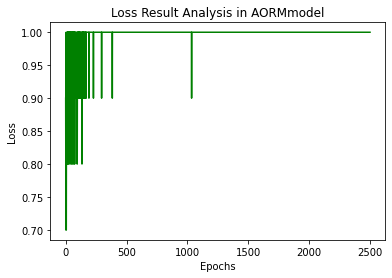

In [17]:
import matplotlib.pyplot as plt
x = np.linspace(0, 2500, 2500)
y1 = np.array([ClassLoss_all[i].item() for i in range(len(ClassLoss_all))])
y2 = np.array([ACC_result[i].item() for i in range(len(ACC_result))])
y3 = np.array([ACC_result[i].item() for i in range(len(F1_result))])

plt.title('Loss Result Analysis in AORMmodel')
# plt.plot(x, y1, color='red', label='Clustering_loss')
# plt.plot(x, y2,  color='blue', label='ACC_result')
plt.plot(x, y3,  color='green', label='F1_result')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### 测试过程

#### 加载模型

In [12]:
model = torch.load('../EMNLP2023/Result/Model_HWU.pt')

#### 加载测试数据

In [22]:
#### Test_All
All_path = '../EMNLP2023/Dataset/Processed/HWU/Test_all.txt'
All_x = []
All_y = []
for line in open(All_path):
    All_y.append(line.split('\t')[1][:-1].replace('_',' '))
    All_x.append(line.split('\t')[0])
print(All_y[:5])
print(All_x[:5])

pre_yd_list = label_yd_yi_dic.keys()
pre_yd_yi_dic = label_yd_yi_dic

All_y_id = []
for i in range(len(All_y)):
    if All_y[i] in pre_yd_list:
        All_y_id.append(pre_yd_yi_dic[All_y[i]])
    else:
        All_y_id.append(cluster_nums_str)  
print("All_y_id:",len(All_y_id))

['alarm remove', 'alarm remove', 'alarm remove', 'alarm remove', 'alarm remove']
['disable the alarm which is set at nine thirty pm', 'delete scheduled alarm', 'turn off my first alarm', 'please cancel all alarms for tomorrow', 'please delete the wednesday evening alarm']
All_y_id: 1674


In [23]:
base_x = []
base_y = []
for i in range(len(All_y)):
    if All_y[i] != 'none of them':
        base_x.append(All_x[i])
        base_y.append(All_y[i])
print(len(base_x))
print(len(set(base_y)))

base_y_id = []
for i in range(len(base_y)):
    if base_y[i] in label_yd_yi_dic.keys():
        base_y_id.append(label_yd_yi_dic[base_y[i]])
    else:
        base_y_id.append(cluster_nums_str)  
print("base_y_id:",len(base_y_id))

548
32
base_y_id: 548


In [24]:
#### Ct_x
Ct_path = '../EMNLP2023/Dataset/Processed/HWU/Test_ood_reduce.txt'
Ct_x = []
Ct_y = []
for line in open(Ct_path):
    Ct_y.append(line.split('\t')[1][:-1].replace('_',' '))
    Ct_x.append(line.split('\t')[0])
print(Ct_x[:5])
print(Ct_y[:5])

pre_yd_list = label_yd_yi_dic.keys()
pre_yd_yi_dic = label_yd_yi_dic

Ct_y_id = []
for i in range(len(Ct_y)):
    if Ct_y[i] in pre_yd_list:
        Ct_y_id.append(pre_yd_yi_dic[Ct_y[i]])
    else:
        Ct_y_id.append(cluster_nums_str)  
print("Ct_y_id:",len(Ct_y_id))

['am i available at five pm on sunday', 'do i have any openings on my schedule for tomorrow', 'do i need to pick up the kids from anything today', 'is the meeting scheduled for tomorrow', 'when the birthday will be']
['none of them', 'none of them', 'none of them', 'none of them', 'none of them']
Ct_y_id: 600


In [25]:
(548+600)/10

114.8

In [26]:
# Ct_x, Ct_y_id 60
# base_x, base_y 191
X = base_x + Ct_x
Y = base_y_id + Ct_y_id
B = 114
test_dataset = AugmentPairSamples(X[:1140],Y[:1140])
test_loader = util_data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)

In [27]:
y_true_list = []
y_pre_list = []
ACC_list = []
F1_list = []
for i in np.arange(B):  ## 25 epochs
    model.training_flag = False        
    print('************'+str(i)+'************')        
    try:
        batch = next(test_loader_iter)
    except:
        test_loader_iter = iter(test_loader)
        batch = next(test_loader_iter)      

    feats, features1, features_none, label = prepare_task_input(batch, is_contrastive=True)    
    _, y_ture, y_pred, Acc, F1 = model.forward(feats, features1, features_none, label, aggregate=True)
    y_true_list += y_ture
    y_pre_list += y_pred
    ACC_list += Acc
    F1_list += F1

************0************


ValueError: invalid literal for int() with base 10: 'alarm set'

In [ ]:
##ALL
print("ACC:",accuracy_score(y_true_list,y_pre_list))
print("F1:",f1_score(y_true_list,y_pre_list, average='macro'))

In [ ]:
##OOD
y_pre_bi = []
y_true_bi = []
for i in range(len(y_pre_list)):
    if y_pre_list[i] == cluster_nums_str:
        y_pre_bi.append(1)
    else:
        y_pre_bi.append(0)
##########
for i in range(len(y_true_list)):
    if y_true_list[i] == cluster_nums_str:
        y_true_bi.append(1)
    else:
        y_true_bi.append(0)
print("ACC:",accuracy_score(y_true_bi,y_pre_bi))
print("F1:",f1_score(y_true_bi,y_pre_bi))

In [35]:
Acc_all = [86.02, 86.61]
F1_all = [86.67, 86.64]
Acc_test = [73.33,72.67,73.17]
F1_test = [84.62,84.17,84.50]

In [36]:
import statistics
import numpy as np

print("********* 1 *********")
Acc_all_std = statistics.stdev(Acc_all)
Acc_all_mean = np.mean(Acc_all)
print(Acc_all_mean)
print(Acc_all_std)

print("********* 2 *********")
F1_all_std = statistics.stdev(F1_all)
F1_all_mean = np.mean(F1_all)
print(F1_all_mean)
print(F1_all_std)

print("********* 3 *********")
Acc_test_std = statistics.stdev(Acc_test)
Acc_test_mean = np.mean(Acc_test)
print(Acc_test_mean)
print(Acc_test_std)

print("********* 4 *********")
F1_test_std = statistics.stdev(F1_test)
F1_test_mean = np.mean(F1_test)
print(F1_test_mean)
print(F1_test_std)

********* 1 *********
86.315
0.41719300090006545
********* 2 *********
86.655
0.02121320343559723
********* 3 *********
73.05666666666667
0.3442867022313415
********* 4 *********
84.43
0.23302360395462177
